<a href="https://colab.research.google.com/github/henrykhlai/LSTM-rescale-precidtion/blob/main/LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#import the python library
%matplotlib inline
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
#Get the stock symbols
#FAANG
assets =['FB','AMZN','AAPL','NFLX','GOOG','NKE','TSLA']
#stock start date
stockStartDate = '2000-01-01'
#stock end date
stockEndDate = datetime.today().strftime('%Y-%m-%d')
#stockEndDate = '2018-12-31'
#Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

#store the adjust the close price
for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end=stockEndDate)['Adj Close']
df

,FB,AMZN,AAPL,NFLX,GOOG,NKE,TSLA
Date,,,,,,,
2012-05-18,38.230000,213.850006,16.288403,9.994286,299.078979,23.707829,5.512000
2012-05-21,34.029999,218.110001,17.237370,10.248571,305.908386,24.110306,5.754000
2012-05-22,31.000000,215.330002,17.105009,9.672857,299.278229,24.384619,6.160000
2012-05-23,32.000000,217.279999,17.522364,10.272857,303.592072,24.175510,6.204000
2012-05-24,33.029999,215.240005,17.361441,10.038571,300.702881,24.166521,6.056000
...,...,...,...,...,...,...,...
2021-05-14,315.940002,3222.899902,127.449997,493.369995,2316.159912,135.929993,589.739990
2021-05-17,315.459991,3270.389893,126.269997,488.940002,2321.409912,136.410004,576.830017
2021-05-18,309.959991,3232.280029,124.849998,486.279999,2303.429932,135.559998,577.869995


In [9]:
data = df['AAPL'].values

In [10]:
timeseries_data = data[:-20]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# scale and revert scale of input
def rescale(x,a,b):
    z = (x-a)/(b-a)
    return z

def revertscale(z,a,b):
    x = z*(b-a)+a
    return x

# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)-n_features):        
        # find the end of this pattern
        end_ix = i + n_features
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def LSTM_predict(timeseries_data, n_steps, n_features=1, predict_steps=20):
    
    # split into samples
    X, y = prepare_data(timeseries_data, n_steps)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0) # vervose = 0 make training Epoch not show

    # Prediction
    x_input = []
    x_input = timeseries_data[-(n_steps):]
    
    '''for i in range(n_steps,0,-1):
        x_input.append(timeseries_data[-i])
    x_input = np.array(x_input) # matrix'''

    x_input = x_input.reshape((1, n_steps, n_features)) # tensor
    yhat = model.predict(x_input, verbose=0)


    predict_output = []
    predict_output.append(yhat)
    x_input = x_input[0]

    xx_input = np.append(x_input[-(n_steps-1):],yhat[0])
    xx_input = xx_input.reshape(n_steps,n_features) #matrix
    #xx_input = np.array([x_input[-2],x_input[-1],yhat[0]]) # matrix
    #print(xx_input.shape)

    for i in range(predict_steps):
        xx_input = xx_input.reshape((1, n_steps, n_features)) # tensor
        # LSTM model only accept tensor as input
        yhat = model.predict(xx_input, verbose=0)

        xx_input = xx_input[0]

        xx_input = np.append(xx_input[-(n_steps-1):],yhat[0])
        xx_input = xx_input.reshape(n_steps,n_features) #matrix

        predict_output.append(yhat[0,0])

    predict_output = np.array(predict_output, dtype=np.float32)
    return predict_output

In [12]:
# define input sequence
timeseries_data = data[:-20]
a = np.min(timeseries_data)
b = np.max(timeseries_data)
date_ahead = 5
XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 25,1,date_ahead)
predict_output = revertscale(yy,a,b)

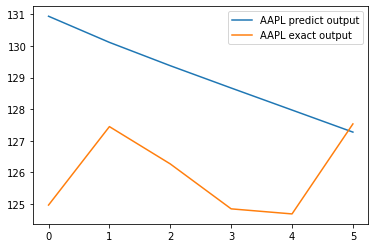

% error:
 [ 4.77653695  2.0896101   2.45916413  3.05994028  2.63362484 -0.20298789]


In [13]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = data[-date_ahead-1:]
plt.plot(predict_output, label ='AAPL predict output')
plt.plot(exact_output, label = 'AAPL exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

## Steps 14 business days

In [15]:
# define input sequence
timeseries_data = data[:-5]
a = np.min(timeseries_data)
b = np.max(timeseries_data)
date_ahead = 5
XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 14,1,date_ahead)
predict_output = revertscale(yy,a,b)

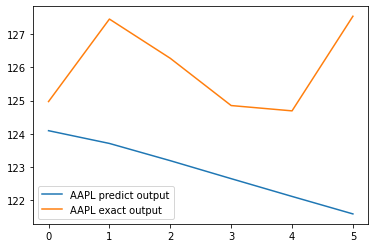

% error:
 [-0.70083348 -2.93412932 -2.43730371 -1.76065162 -2.06314268 -4.66016099]


In [16]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = data[-date_ahead-1:]
plt.plot(predict_output, label ='AAPL predict output')
plt.plot(exact_output, label = 'AAPL exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

## Amazon

In [5]:
amazon = df['AMZN'].values

In [21]:
# define input sequence
timeseries_data = amazon[:-5]
a = np.min(timeseries_data)
b = np.max(timeseries_data)
date_ahead = 5
XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 14,1,date_ahead)
predict_output = revertscale(yy,a,b)

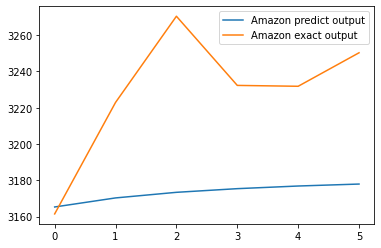

% error:
 [ 0.12100192 -1.63262656 -2.96668654 -1.76015277 -1.70046307 -2.22565243]


In [20]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = amazon[-date_ahead-1:]
plt.plot(predict_output, label ='Amazon predict output')
plt.plot(exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

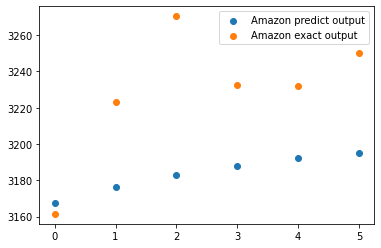

% error:
 [ 0.18943763 -1.45423854 -2.67540252 -1.37065682 -1.23114318 -1.69353685]


In [28]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = amazon[-date_ahead-1:]
plt.scatter(range(0,6),predict_output, label ='Amazon predict output')
plt.scatter(range(0,6), exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

7 days steps

In [10]:
# define input sequence
timeseries_data = amazon[:-7]
a = np.min(timeseries_data)
b = np.max(timeseries_data)
date_ahead = 5
XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 7, 1, date_ahead)
predict_output = revertscale(yy,a,b)

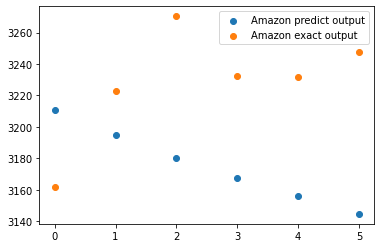

% error:
 [ 1.56312491 -0.87100233 -2.76417103 -1.99608457 -2.34627462 -3.17359215]


In [9]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = amazon[-date_ahead-1:]
plt.scatter(range(0,6),predict_output, label ='Amazon predict output')
plt.scatter(range(0,6), exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

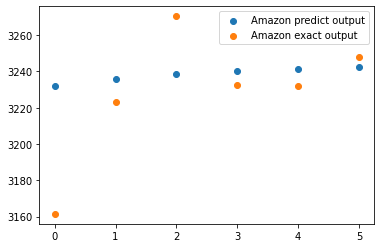

% error:
 [ 2.22380514  0.40209839 -0.97981287  0.24618905  0.30255065 -0.16439019]


In [11]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = amazon[-date_ahead-1:]
plt.scatter(range(0,6),predict_output, label ='Amazon predict output')
plt.scatter(range(0,6), exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 